In [2]:
import Thermobar as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import pickle

## Loading machine learning model

In [3]:
with open('svc_model_linear_MinClass.pkl', 'rb') as f:
        svc_model=load(f)
with open('scaler_MinClass.pkl', 'rb') as f:
        scaler=load(f)

In [39]:
_Min_Group_M_Min_Group_M_Min_Group_M

## Jordans Galan data

In [54]:
def classify_phases(filename, sheet_name, return_end_members=False):
    Excel_In=pt.import_excel(filename, sheet_name)
    Oxides=Excel_In['my_oxides']
    with open('svc_model_linear_MinClass.pkl', 'rb') as f:
        svc_model=load(f)
    with open('scaler_MinClass.pkl', 'rb') as f:
        scaler=load(f)  
        
    # Dropping things which are often missing
    Oxides_dropoxides=Oxides.drop(columns=['Cr2O3', 'K2O', 'P2O5'])
    X_in=Oxides_dropoxides.values
    
    ## This does the machine learning classification
    X_in_scaled= scaler.transform(X_in)
    svc_predictions=svc_model.predict(X_in_scaled) 
    Oxides_out=Oxides.copy()
    Oxides_out['Sum_Oxides']=Oxides.sum(axis=1)
    Oxides_out['Phase_Min_Group_ML']=svc_predictions
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(0, "Amp")    
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(1, "Px")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(2, "Fspar")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(3, "Ol")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(4, "Sp")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(5, "Ox")

    
    Oxides_out.loc[Oxides_out['Sum_Oxides']<90, 'Phase_Min_Group_ML'] = "Not Classified - Total<90"    
    Oxides_out.loc[Oxides_out['Sum_Oxides']>110, 'Phase_Min_Group_ML'] = "Not Classified - Total>110"
    Oxides_out['Phase_Mineral']=Oxides_out['Phase_Min_Group_ML']
    
    #This does manual classification for feldsdpars.
    Fspar=Oxides_out['Phase_Min_Group_ML']=="Fspar" # This checks we are only doing it for felspar
    Oxides_Fspar=Oxides_out.add_suffix('_Plag')
    Fspar_components=pt.calculate_cat_fractions_plagioclase(plag_comps=Oxides_Fspar)
    Fspar_An=Fspar_components['An_Plag']
    Fspar_Ab=Fspar_components['Ab_Plag']
    Fspar_Or=Fspar_components['Or_Plag']  
    if return_end_members==True:
        Oxides_out['Ab']=Fspar_Ab
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Ab']="N/A"
        Oxides_out['An']=Fspar_An
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'An']="N/A"
        Oxides_out['Or']=Fspar_Or
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Or']="N/A"
        
    Oxides_out.loc[( (Fspar) & (Fspar_An>0.1) & (Fspar_Or<0.1) ), 'Phase_Mineral'] = "Plag"    
    Oxides_out.loc[( (Fspar) & (Fspar_Or>0.1) & (Fspar_An<0.1)), 'Phase_Mineral'] = "Kspar"    
    Oxides_out.loc[(Fspar & (Fspar_An<0.1) &  (Fspar_Or<0.1)), 'Phase_Mineral'] = "Albite"      
    
    Oxides_out['Fspar_Class']=Oxides_out['Phase_Min_Group_ML']

    Oxides_out.loc[( (Fspar) & (Fspar_An<0.1) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Albite"                        
    Oxides_out.loc[( (Fspar) & (Fspar_Or.between(0.1, 0.37) ) &  (Fspar_An<0.2)), 'Fspar_Class'] = "Anorthoclase"                        
    Oxides_out.loc[( (Fspar) & (Fspar_Or>0.37) &  (Fspar_An<0.2) ), 'Fspar_Class'] = "Sanidine"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.1, 0.3)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Oligoclase"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.3, 0.5)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Andesine"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.5, 0.7)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Bytownite"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An>0.9) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Anorthite"                        
    Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Fspar_Class']="N/A"
    
    # This does Manual Classification for Pyroxenes
    Oxides_Pyroxenes=Oxides_out.add_suffix('_Opx')
    Px=Oxides_out['Phase_Min_Group_ML']=="Px"

    Px_components=pt.calculate_orthopyroxene_components(opx_comps=Oxides_Pyroxenes)
    Px_CaMgFe=Px_components['Ca_CaMgFe']
    Oxides_out.loc[( (Px) & (Px_CaMgFe<0.05) ), 'Phase_Mineral'] = "Opx"     
    Oxides_out.loc[( (Px) & (Px_CaMgFe.between(0.05, 0.2)) ), 'Phase_Mineral'] = "Pig"     
    Oxides_out.loc[( (Px) & (Px_CaMgFe>0.2) ), 'Phase_Mineral'] = "Cpx" 
    if return_end_members==True:
        Oxides_out['Ca/CaMgFe Px']=Px_CaMgFe
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Px", 'Ca/CaMgFe']="N/A"    

    # This does manual classification for amphiboles, based on Leake (1997)
    
    
    return Oxides_out

In [55]:
Galan=classify_phases('Galan_plag_oxides.xlsx', sheet_name='oxides', return_end_members=True)
Galan

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
0,54.222949,0.005338,29.043135,0.0,0.0,0.000000,11.338169,4.641997,0.274048,0.0,0.0,99.525636,Fspar,Plag,0.41865,0.565087,0.016262,Bytownite,1.000000,N/A
1,59.963641,0.002335,24.441535,0.0,0.0,0.000000,5.982782,7.207719,0.824191,0.0,0.0,98.422204,Fspar,Plag,0.651915,0.299035,0.049049,Oligoclase,1.000000,N/A
2,58.288756,0.008007,25.793447,0.0,0.0,0.002487,7.559945,6.370226,0.585679,0.0,0.0,98.608547,Fspar,Plag,0.582641,0.382112,0.035247,Andesine,0.999542,N/A
3,60.637746,0.011176,24.388819,0.0,0.0,0.000000,5.920378,7.319465,0.829852,0.0,0.0,99.107437,Fspar,Plag,0.657208,0.293764,0.049027,Oligoclase,1.000000,N/A
4,59.899248,0.002168,24.970396,0.0,0.0,0.003317,6.479214,7.045423,0.821902,0.0,0.0,99.221668,Fspar,Plag,0.630928,0.320643,0.048429,Andesine,0.999288,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,56.011434,0.008841,28.368219,0.0,0.0,0.000000,10.380706,5.206391,0.374873,0.0,0.0,100.350462,Fspar,Plag,0.465287,0.512669,0.022043,Bytownite,1.000000,N/A
64,55.733320,0.017181,28.509362,0.0,0.0,0.000000,10.483965,5.079817,0.329821,0.0,0.0,100.153465,Fspar,Plag,0.458034,0.522398,0.019568,Bytownite,1.000000,N/A
65,57.974915,0.007506,26.091037,0.0,0.0,0.003317,8.265415,6.035661,0.508343,0.0,0.0,98.886194,Fspar,Plag,0.551818,0.417601,0.03058,Andesine,0.999442,N/A
66,61.291313,0.002836,24.551502,0.0,0.0,0.000663,6.235615,7.065373,0.758299,0.0,0.0,99.905601,Fspar,Plag,0.641709,0.312974,0.045316,Andesine,0.999852,N/A


In [58]:
Galan=classify_phases('CT_sanidine_supplementary_data.xlsx', sheet_name='EPMA analyses', return_end_members=True)
sum(Galan['Fspar_Class']!="Sanidine")


0

In [64]:
## Importing Hannas data
Hannah=classify_phases('KSpars_Shamloo.xlsx', sheet_name='alkali feldspar', return_end_members=True)
sum(Hannah['Fspar_Class']!="Sanidine")

1

In [66]:
Hannah.loc[Hannah['Fspar_Class']!="Sanidine"]

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
669,0.213579,0.0,0.175234,0.0,0.0,0.0,0.002787,0.03206,0.111567,0.0,0.0,0.535227,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,1.0,N/A


## Importing Jordans data

In [69]:
classify_phases('Toba_master_spots.xlsx', sheet_name='plagioclase', return_end_members=True)

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
0,61.44,0.00,24.86,0.17,0.0,0.01,6.07,6.88,0.97,0.0,0.0,100.40,Fspar,Plag,0.632781,0.308517,0.058701,Andesine,0.976418,N/A
1,60.63,0.01,24.49,0.16,0.0,0.00,6.23,6.92,0.86,0.0,0.0,99.30,Fspar,Plag,0.633196,0.315026,0.051778,Andesine,0.980349,N/A
2,56.48,0.01,25.95,0.21,0.0,0.00,8.21,6.00,0.59,0.0,0.0,97.45,Fspar,Plag,0.549188,0.415278,0.035533,Andesine,0.980426,N/A
3,56.68,0.01,26.78,0.17,0.0,0.01,9.00,5.79,0.49,0.0,0.0,98.93,Fspar,Plag,0.522281,0.448636,0.029083,Andesine,0.983972,N/A
4,58.19,0.00,26.06,0.20,0.0,0.01,7.90,6.10,0.62,0.0,0.0,99.08,Fspar,Plag,0.56099,0.401493,0.037517,Andesine,0.978932,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,57.19,0.00,25.33,0.21,0.0,0.01,7.36,6.47,0.63,0.0,0.0,97.20,Fspar,Plag,0.59077,0.37138,0.03785,Andesine,0.976409,N/A
170,62.05,0.00,24.36,0.17,0.0,0.00,5.62,7.30,1.02,0.0,0.0,100.52,Fspar,Plag,0.659032,0.280379,0.060589,Oligoclase,0.976935,N/A
171,59.66,0.01,24.95,0.16,0.0,0.00,6.45,6.84,0.85,0.0,0.0,98.92,Fspar,Plag,0.623878,0.325109,0.051012,Andesine,0.981006,N/A
172,59.86,0.00,24.73,0.16,0.0,0.00,6.33,6.94,0.87,0.0,0.0,98.89,Fspar,Plag,0.630306,0.317703,0.05199,Andesine,0.980653,N/A


In [5]:
Jordan_Plag_in=pt.import_excel('Toba_master_spots.xlsx', sheet_name='plagioclase')
Jordan_Plag_in

In [6]:
Jordan_Plag_Ox_noclass=Jordan_Plag_Ox.drop(columns=['Cr2O3', 'K2O', 'P2O5'])

In [7]:
Jordan_Plag_Ox_noclass

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O
0,61.44,0.00,24.86,0.17,0.0,0.01,6.07,6.88
1,60.63,0.01,24.49,0.16,0.0,0.00,6.23,6.92
2,56.48,0.01,25.95,0.21,0.0,0.00,8.21,6.00
3,56.68,0.01,26.78,0.17,0.0,0.01,9.00,5.79
4,58.19,0.00,26.06,0.20,0.0,0.01,7.90,6.10
...,...,...,...,...,...,...,...,...
169,57.19,0.00,25.33,0.21,0.0,0.01,7.36,6.47
170,62.05,0.00,24.36,0.17,0.0,0.00,5.62,7.30
171,59.66,0.01,24.95,0.16,0.0,0.00,6.45,6.84
172,59.86,0.00,24.73,0.16,0.0,0.00,6.33,6.94


In [8]:
X_Jordan_Plag=Jordan_Plag_Ox_noclass.values
X_Jordan_Plag_scaled= scaler.transform(X_Jordan_Plag)
svc_predictions_Jordan_Plag=svc_model.predict(X_Jordan_Plag_scaled)

In [9]:
Jordan_Plag_Ox_noclass['Phase']=svc_predictions_Jordan_Plag

In [10]:
Jordan_Plag_Ox_noclass[['Phase']]=Jordan_Plag_Ox_noclass[['Phase']].replace(2, "Fspar")

In [11]:
Jordan_Plag_Ox_noclass[['Phase']]

,Phase
0,Fspar
1,Fspar
2,Fspar
3,Fspar
4,Fspar
...,...
169,Fspar
170,Fspar
171,Fspar
172,Fspar


In [12]:
notPlag=Jordan_Plag_Ox_noclass['Phase']!=2

In [13]:
Jordan_Plag_Ox_noclass.loc[notPlag]

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,Phase
0,61.44,0.00,24.86,0.17,0.0,0.01,6.07,6.88,Fspar
1,60.63,0.01,24.49,0.16,0.0,0.00,6.23,6.92,Fspar
2,56.48,0.01,25.95,0.21,0.0,0.00,8.21,6.00,Fspar
3,56.68,0.01,26.78,0.17,0.0,0.01,9.00,5.79,Fspar
4,58.19,0.00,26.06,0.20,0.0,0.01,7.90,6.10,Fspar
...,...,...,...,...,...,...,...,...,...
169,57.19,0.00,25.33,0.21,0.0,0.01,7.36,6.47,Fspar
170,62.05,0.00,24.36,0.17,0.0,0.00,5.62,7.30,Fspar
171,59.66,0.01,24.95,0.16,0.0,0.00,6.45,6.84,Fspar
172,59.86,0.00,24.73,0.16,0.0,0.00,6.33,6.94,Fspar


In [33]:
Oxides_out=classify_phases('Toba_master_spots.xlsx', sheet_name='inclusions')

Text(0, 0.5, 'Mg/Mg+Fe')

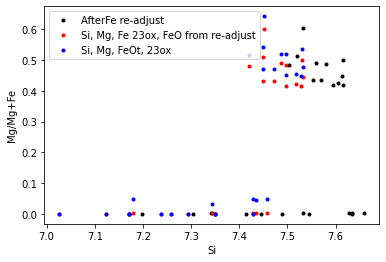

In [34]:
Oxides_Amphiboles=Oxides_out.add_suffix('_Amp')
amp_sites=pt.get_amp_sites_from_input(amp_comps=Oxides_Amphiboles)
amp_cations=pt.calculate_23oxygens_amphibole(amp_comps=Oxides_Amphiboles)
ferric_ferrous=pt.amp_components_ferric_ferrous(amp_sites, amp_cations)
plt.plot(ferric_ferrous['SiO2'], ferric_ferrous['MgO']/(ferric_ferrous['MgO']+ferric_ferrous['FeO']), '.k', label='AfterFe re-adjust')
plt.plot(amp_cations['SiO2_Amp_cat_23ox'], amp_cations['MgO_Amp_cat_23ox']
         /(amp_cations['MgO_Amp_cat_23ox']+ferric_ferrous['FeO']), '.r', label='Si, Mg, Fe 23ox, FeO from re-adjust')
plt.plot(amp_cations['SiO2_Amp_cat_23ox'], amp_cations['MgO_Amp_cat_23ox']/
         (amp_cations['MgO_Amp_cat_23ox']+amp_cations['FeOt_Amp_cat_23ox']), '.b', label='Si, Mg, FeOt, 23ox')
plt.legend()
plt.xlabel('Si')
plt.ylabel('Mg/Mg+Fe')

In [23]:
amp_cations

,SiO2_Amp_cat_23ox,MgO_Amp_cat_23ox,FeOt_Amp_cat_23ox,CaO_Amp_cat_23ox,Al2O3_Amp_cat_23ox,Na2O_Amp_cat_23ox,K2O_Amp_cat_23ox,MnO_Amp_cat_23ox,TiO2_Amp_cat_23ox,Cr2O3_Amp_cat_23ox,oxy_renorm_factor,cation_sum_Si_Mg,cation_sum_Si_Ca,cation_sum_All
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.497564,3.927727,3.632365,0.124018,0.124481,0.005610,0.000000,0.102941,0.014148,0.0,0.0,15.299224,15.423243,15.428853
2,7.516749,3.388177,4.036512,0.144272,0.092427,0.002869,0.000000,0.241885,0.007791,0.0,0.0,15.283541,15.427812,15.430681
3,7.531023,4.045832,3.500822,0.118845,0.095074,0.008379,0.000000,0.106151,0.009752,0.0,0.0,15.288653,15.407499,15.415878
4,7.531859,3.547478,3.896750,0.130390,0.105409,0.002843,0.000000,0.180072,0.011029,0.0,0.0,15.272596,15.402986,15.405829
5,7.449794,3.553088,4.006171,0.129662,0.107838,0.002861,0.000000,0.215000,0.016651,0.0,0.0,15.348543,15.478205,15.481066
6,7.350629,0.000000,0.030710,1.138302,4.227910,1.497612,0.074309,0.000000,0.000952,0.0,0.0,11.610202,12.748503,14.320424
7,7.471220,3.544452,3.985384,0.153578,0.102753,0.002865,0.000000,0.185239,0.016673,0.0,0.0,15.305720,15.459298,15.462163
8,7.451364,4.853835,2.699452,0.177284,0.165261,0.005437,0.000000,0.076012,0.020040,0.0,0.0,15.265963,15.443247,15.448684
9,7.486483,3.866756,3.556042,0.162659,0.161881,0.008410,0.000000,0.164099,0.015226,0.0,0.0,15.250487,15.413146,15.421556


In [22]:
ferric_ferrous

,SiO2,MgO,CaO,Al2O3,Na2O,K2O,MnO,TiO2,Cr2O3,Fe2O3,FeO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.580581,3.971217,0.125392,0.125859,0.005673,0.000000,0.104081,0.014305,0.0,-0.509342,4.181926
2,7.605568,3.428212,0.145976,0.093519,0.002903,0.000000,0.244743,0.007883,0.0,-0.543543,4.627751
3,7.616053,4.091512,0.120187,0.096148,0.008473,0.000000,0.107349,0.009862,0.0,-0.519370,4.059718
4,7.612194,3.585315,0.131781,0.106534,0.002873,0.000000,0.181992,0.011146,0.0,-0.490638,4.428950
5,7.552740,3.602187,0.131454,0.109329,0.002901,0.000000,0.217971,0.016881,0.0,-0.635655,4.697185
6,7.545122,0.000000,1.168420,4.339778,1.537238,0.076275,0.000000,0.000978,0.0,-1.217129,1.248651
7,7.570358,3.591484,0.155616,0.104116,0.002903,0.000000,0.187697,0.016894,0.0,-0.610389,4.648657
8,7.531959,4.906334,0.179201,0.167049,0.005496,0.000000,0.076834,0.020257,0.0,-0.497543,3.226192
9,7.558243,3.903820,0.164218,0.163433,0.008490,0.000000,0.165672,0.015372,0.0,-0.440922,4.031049


In [18]:
plt.plot(amp_sites['Si_T']

,Si_T,Al_T,Al_C,Ti_C,Mg_C,Fe_C,Mn_C,Cr_C,Mg_B,Fe_B,Mn_B,Na_B,Ca_B,Na_A,K_A
0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,7.497564,0.124481,0.000000,0.014148,3.927727,1.058125,0.0,0.0,0.0,2.574239,0.102941,0.000000,0.124018,0.005610,0.000000
2,7.516749,0.092427,0.000000,0.007791,3.388177,1.604032,0.0,0.0,0.0,2.432480,0.241885,0.000000,0.144272,0.002869,0.000000
3,7.531023,0.095074,0.000000,0.009752,4.045832,0.944416,0.0,0.0,0.0,2.556405,0.106151,0.000000,0.118845,0.008379,0.000000
4,7.531859,0.105409,0.000000,0.011029,3.547478,1.441494,0.0,0.0,0.0,2.455256,0.180072,0.000000,0.130390,0.002843,0.000000
5,7.449794,0.107838,0.000000,0.016651,3.553088,1.430260,0.0,0.0,0.0,2.575910,0.215000,0.000000,0.129662,0.002861,0.000000
6,7.350629,0.649371,3.578539,0.000952,0.000000,1.420508,0.0,0.0,0.0,-1.389798,0.000000,2.251497,1.138302,-0.753885,0.074309
7,7.471220,0.102753,0.000000,0.016673,3.544452,1.438876,0.0,0.0,0.0,2.546509,0.185239,0.000000,0.153578,0.002865,0.000000
8,7.451364,0.165261,0.000000,0.020040,4.853835,0.126125,0.0,0.0,0.0,2.573326,0.076012,0.000000,0.177284,0.005437,0.000000
9,7.486483,0.161881,0.000000,0.015226,3.866756,1.118018,0.0,0.0,0.0,2.438023,0.164099,0.000000,0.162659,0.008410,0.000000


In [113]:
Jordan_Class_inc=classify_phases('Toba_master_spots.xlsx', sheet_name='inclusions')
Jordan_Class_inc

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Fspar_Class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,Not Classified - Total<90,Not Classified - Total<90,N/A
1,51.82,0.13,0.73,30.02,0.84,18.21,0.80,0.02,0.00,0.0,0.0,102.57,Px,Opx,N/A
2,50.80,0.07,0.53,32.62,1.93,15.36,0.91,0.01,0.00,0.0,0.0,102.23,Px,Opx,N/A
3,52.28,0.09,0.56,29.06,0.87,18.84,0.77,0.03,0.00,0.0,0.0,102.50,Px,Opx,N/A
4,51.37,0.10,0.61,31.78,1.45,16.23,0.83,0.01,0.00,0.0,0.0,102.38,Px,Opx,N/A
5,50.48,0.15,0.62,32.46,1.72,16.15,0.82,0.01,0.00,0.0,0.0,102.41,Px,Opx,N/A
6,58.05,0.01,28.33,0.29,0.00,0.00,8.39,6.10,0.46,0.0,0.0,101.63,Fspar,Kspar,N/A
7,50.56,0.15,0.59,32.25,1.48,16.09,0.97,0.01,0.00,0.0,0.0,102.10,Px,Opx,N/A
8,53.14,0.19,1.00,23.02,0.64,23.22,1.18,0.02,0.00,0.0,0.0,102.41,Px,Opx,N/A
9,51.78,0.14,0.95,29.41,1.34,17.94,1.05,0.03,0.00,0.0,0.0,102.64,Px,Opx,N/A


In [109]:
Oxides_out=Jordan_Class_inc
Px=Oxides_out['Phase_Min_Group_ML']=="Px"
Px

0     False
1      True
2      True
3      True
4      True
5      True
6     False
7      True
8      True
9      True
10     True
11    False
12     True
13     True
14    False
15     True
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
Name: Phase_Min_Group_ML, dtype: bool

In [92]:
Jordan_Class_Plag=classify_phases('Toba_master_spots.xlsx', sheet_name='plagioclase')
sum(Jordan_Class_Plag['Phase_Min_Group_ML'] !="Fspar")
# Empty row
Jordan_Class_Plag.to_clipboard(excel=True)

In [19]:
Jordan_Class_inc=classify_phases('Toba_master_spots.xlsx', sheet_name='inclusions')
Jordan_Class_inc.to_clipboard(excel=True)

In [22]:
df=Jordan_Class_inc
df.loc[df['Sum_Oxides']<90, 'Phase_Min_Group_ML'] = "Not Classified - Low Total"

In [23]:
df

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Phase_ML_svc,Sum_Oxides
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,Not Classified - Low Total,0.00
1,51.82,0.13,0.73,30.02,0.84,18.21,0.80,0.02,0.00,0.0,0.0,Px,102.57
2,50.80,0.07,0.53,32.62,1.93,15.36,0.91,0.01,0.00,0.0,0.0,Px,102.23
3,52.28,0.09,0.56,29.06,0.87,18.84,0.77,0.03,0.00,0.0,0.0,Px,102.50
4,51.37,0.10,0.61,31.78,1.45,16.23,0.83,0.01,0.00,0.0,0.0,Px,102.38
5,50.48,0.15,0.62,32.46,1.72,16.15,0.82,0.01,0.00,0.0,0.0,Px,102.41
6,58.05,0.01,28.33,0.29,0.00,0.00,8.39,6.10,0.46,0.0,0.0,Fspar,101.63
7,50.56,0.15,0.59,32.25,1.48,16.09,0.97,0.01,0.00,0.0,0.0,Px,102.10
8,53.14,0.19,1.00,23.02,0.64,23.22,1.18,0.02,0.00,0.0,0.0,Px,102.41
9,51.78,0.14,0.95,29.41,1.34,17.94,1.05,0.03,0.00,0.0,0.0,Px,102.64


In [36]:
Jordan_Class_Amp=classify_phases('Toba_master_spots.xlsx', sheet_name='amphibole')
sum(Jordan_Class_Amp['Phase_Min_Group_ML'] !="Amp")
# Empty row

0

In [39]:
Jordan_Class_inc=classify_phases('Toba_master_spots.xlsx', sheet_name='inclusions')
Jordan_Class_inc.to_clipboard(excel=True)

In [40]:
Jordan_Class_inc

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Phase_ML_svc
0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,Sp
1,51.82,0.13,0.73,0.0,0.84,18.21,0.80,0.02,0.00,0.0,0.0,Px
2,50.80,0.07,0.53,0.0,1.93,15.36,0.91,0.01,0.00,0.0,0.0,Px
3,52.28,0.09,0.56,0.0,0.87,18.84,0.77,0.03,0.00,0.0,0.0,Px
4,51.37,0.10,0.61,0.0,1.45,16.23,0.83,0.01,0.00,0.0,0.0,Px
5,50.48,0.15,0.62,0.0,1.72,16.15,0.82,0.01,0.00,0.0,0.0,Px
6,58.05,0.01,28.33,0.0,0.00,0.00,8.39,6.10,0.46,0.0,0.0,Fspar
7,50.56,0.15,0.59,0.0,1.48,16.09,0.97,0.01,0.00,0.0,0.0,Px
8,53.14,0.19,1.00,0.0,0.64,23.22,1.18,0.02,0.00,0.0,0.0,Px
9,51.78,0.14,0.95,0.0,1.34,17.94,1.05,0.03,0.00,0.0,0.0,Px


## Importing data for Amp (Phase=0)

In [3]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Amp_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Amp")
    LEPR_Amp_PreFilt=LEPR_Amp_in['Amps']
LEPR_Amp_Sums=pt.calculate_23oxygens_amphibole(amp_comps=LEPR_Amp_PreFilt).cation_sum_All
LEPR_Amp=LEPR_Amp_PreFilt.loc[LEPR_Amp_Sums.between(15.5, 16)]
LEPR_Amp_nosuf=LEPR_Amp.copy()
LEPR_Amp_nosuf.drop(columns=['F_Amp', 'Cl_Amp'], inplace=True)
LEPR_Amp_nosuf.columns = [col.replace('_Amp', '') for col in LEPR_Amp_nosuf.columns]
LEPR_Amp_nosuf['Phase']=0

## Importing data Cpx (phase=1)

In [4]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Cpx_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Cpx")
    LEPR_px_input=LEPR_Cpx_in['my_input']
    LEPR_Cpx_PreFilt=LEPR_Cpx_in['Cpxs']

LEPR_Cpx_cs=pt.calculate_clinopyroxene_components(cpx_comps=LEPR_Cpx_PreFilt)
LEPR_Cpx_Sums=LEPR_Cpx_cs.Cation_Sum_Cpx
LEPR_CaCaMgFe=LEPR_Cpx_cs.Ca_CaMgFe
LEPR_Cpx=LEPR_Cpx_PreFilt.loc[(LEPR_Cpx_Sums.between(a, b))]
LEPR_Cpx_nosuf=LEPR_Cpx.copy()
LEPR_Cpx_nosuf.columns = [col.replace('_Cpx', '') for col in LEPR_Cpx_nosuf.columns]
LEPR_Cpx_nosuf['Phase']=1


## Importing data Opx (Phase=1)

In [28]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')    
    LEPR_Opx_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Opx")
    LEPR_px_input=LEPR_Opx_in['my_input']
    LEPR_Opx_PreFilt=LEPR_Opx_in['Opxs']

LEPR_Opx_cs=pt.calculate_orthopyroxene_components(opx_comps=LEPR_Opx_PreFilt)
LEPR_Opx_Sums=LEPR_Opx_cs.Cation_Sum_Opx
LEPR_CaCaMgFe=LEPR_Opx_cs.Ca_CaMgFe


LEPR_Opx=LEPR_Opx_PreFilt.loc[(LEPR_Opx_Sums.between(a, b)) ]


LEPR_Opx_nosuf=LEPR_Opx.copy()
LEPR_Opx_nosuf.columns = [col.replace('_Opx', '') for col in LEPR_Opx_nosuf.columns]

LEPR_Opx_nosuf['Phase']=1

## Importing data for Plag (Phase=2)

In [29]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')    
    LEPR_Plag_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Plag")
    LEPR_px_input=LEPR_Plag_in['my_input']
    LEPR_Plag_PreFilt=LEPR_Plag_in['Plags']


LEPR_Plag=LEPR_Plag_PreFilt


LEPR_Plag_nosuf=LEPR_Plag.copy()
LEPR_Plag_nosuf.columns = [col.replace('_Plag', '') for col in LEPR_Plag_nosuf.columns]


LEPR_Plag_nosuf['Phase']=2

## Importing data for olivine (Phase = 3)

In [30]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')    
    LEPR_Ol_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Ol")
    LEPR_px_input=LEPR_Ol_in['my_input']
    LEPR_Ol_PreFilt=LEPR_Ol_in['Ols']


LEPR_Ol=LEPR_Ol_PreFilt


LEPR_Ol_nosuf=LEPR_Ol.copy()
LEPR_Ol_nosuf.columns = [col.replace('_Ol', '') for col in LEPR_Ol_nosuf.columns]

LEPR_Ol_nosuf['Phase']=3

## Importing Spinel data (Phase = 4)

In [32]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Sp_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Cr_Sp")
    LEPR_Sp_input=LEPR_Sp_in['my_input']
    LEPR_Sp_PreFilt=LEPR_Sp_in['Sps']

LEPR_Sp=LEPR_Sp_PreFilt
LEPR_Sp_nosuf=LEPR_Sp.copy()
LEPR_Sp_nosuf.columns = [col.replace('_Sp', '') for col in LEPR_Sp_nosuf.columns]
LEPR_Sp_nosuf['Phase']=4


## Importing Oxide, phase = 5

In [33]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Ox_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Oxide")
    LEPR_Ox_input=LEPR_Ox_in['my_input']
    LEPR_Ox_PreFilt=LEPR_Ox_in['Sps']


LEPR_Ox=LEPR_Ox_PreFilt

LEPR_Ox_nosuf=LEPR_Ox.copy()
LEPR_Ox_nosuf.columns = [col.replace('_Sp', '') for col in LEPR_Ox_nosuf.columns]
LEPR_Ox_nosuf['Phase']=5


## Alk Feldspar Phase = 2

In [34]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')    
    LEPR_Kspar_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Kspar")
    LEPR_px_input=LEPR_Kspar_in['my_input']
    LEPR_Kspar_PreFilt=LEPR_Kspar_in['Kspars']


LEPR_Kspar=LEPR_Kspar_PreFilt


LEPR_Kspar_nosuf=LEPR_Kspar.copy()
LEPR_Kspar_nosuf.columns = [col.replace('_Kspar', '') for col in LEPR_Kspar_nosuf.columns]


LEPR_Kspar_nosuf['Phase']=2

## Stitching different phases together

In [35]:
LEPR_Combo=pd.concat([LEPR_Cpx_nosuf, LEPR_Amp_nosuf, LEPR_Opx_nosuf,  LEPR_Plag_nosuf, 
                      LEPR_Ol_nosuf,  LEPR_Sp_nosuf, LEPR_Ox_nosuf, LEPR_Kspar_nosuf], axis=0, ignore_index=True)#.reset_index(drop=True, inplace=True)
LEPR_Y=LEPR_Combo['Phase']
LEPR_Combo_noclass=LEPR_Combo.drop(columns=['Phase', 'Sample_ID', 'NiO', 'Cr2O3', 'K2O'])
LEPR_X=LEPR_Combo_noclass.values

## Importing new data from my compilation

In [36]:
PW_Amp_in=pt.import_excel(r"C:\Users\penny\OneDrive - Oregon State University\Postdoc\PyMME\MyBarometers\LEPR_Tests\LEPR_Wet_Stitched.xlsx", sheet_name="Amp")
PW_Amp_input=PW_Amp_in['my_input']
PW_Amp_PreFilt=PW_Amp_in['Amps']
PW_Amp_Sums=pt.calculate_23oxygens_amphibole(amp_comps=PW_Amp_PreFilt).cation_sum_All
PW_Amp=PW_Amp_PreFilt.loc[PW_Amp_Sums.between(15.5, 16)]
PW_Amp_nosuf=PW_Amp.copy()
PW_Amp_nosuf.drop(columns=['F_Amp', 'Cl_Amp'], inplace=True)
PW_Amp_nosuf.columns = [col.replace('_Amp', '') for col in PW_Amp_nosuf.columns]
PW_Amp_nosuf['Phase']=0

In [37]:
PW_Cpx_in=pt.import_excel(r"C:\Users\penny\OneDrive - Oregon State University\Postdoc\PyMME\MyBarometers\LEPR_Tests\LEPR_Wet_Stitched.xlsx", sheet_name="Cpx")
PW_Cpx_input=PW_Cpx_in['my_input']
PW_Cpx_PreFilt=PW_Cpx_in['Cpxs']
PW_Cpx_cs=pt.calculate_clinopyroxene_components(cpx_comps=PW_Cpx_PreFilt)
PW_Cpx_Sums=PW_Cpx_cs.Cation_Sum_Cpx
PW_CaCaMgFe=PW_Cpx_cs.Ca_CaMgFe


PW_Cpx=PW_Cpx_PreFilt.loc[(PW_Cpx_Sums.between(a, b)) & (PW_CaCaMgFe>0.2) ]


PW_Cpx_nosuf=PW_Cpx.copy()
PW_Cpx_nosuf.columns = [col.replace('_Cpx', '') for col in PW_Cpx_nosuf.columns]

PW_Cpx_nosuf['Phase']=1


In [61]:
PW_Opx_in=pt.import_excel(r"C:\Users\penny\OneDrive - Oregon State University\Postdoc\PyMME\MyBarometers\LEPR_Tests\LEPR_Wet_Stitched.xlsx", sheet_name="Opx")
PW_Opx_input=PW_Opx_in['my_input']
PW_Opx_PreFilt=PW_Opx_in['Opxs']
PW_Opx_cs=pt.calculate_orthopyroxene_components(opx_comps=PW_Opx_PreFilt)
PW_Opx_Sums=PW_Opx_cs.Cation_Sum_Opx
PW_CaCaMgFe=PW_Opx_cs.Ca_CaMgFe


PW_Opx=PW_Opx_PreFilt.loc[(PW_Opx_Sums.between(a, b)) & (PW_CaCaMgFe<0.05) ]


PW_Opx_nosuf=PW_Opx.copy()
PW_Opx_nosuf.columns = [col.replace('_Opx', '') for col in PW_Opx_nosuf.columns]

PW_Opx_nosuf['Phase']=1


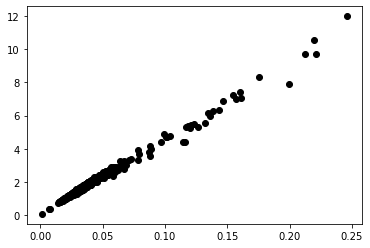

In [62]:
plt.plot(PW_Opx_cs['Ca_CaMgFe'], PW_Opx_PreFilt['CaO_Opx'], 'ok')

In [63]:
PW_Plag_in=pt.import_excel(r"C:\Users\penny\OneDrive - Oregon State University\Postdoc\PyMME\MyBarometers\LEPR_Tests\LEPR_Wet_Stitched.xlsx", 
                           sheet_name="Plag-Liq")
PW_Plag_input=PW_Plag_in['my_input']
PW_Plag_PreFilt=PW_Plag_in['Plags']


PW_Plag=PW_Plag_PreFilt


PW_Plag_nosuf=PW_Plag.copy()
PW_Plag_nosuf.columns = [col.replace('_Plag', '') for col in PW_Plag_nosuf.columns]

PW_Plag_nosuf['Phase']=2


In [64]:
PW_Ol_in=pt.import_excel(r"C:\Users\penny\OneDrive - Oregon State University\Postdoc\PyMME\MyBarometers\LEPR_Tests\LEPR_Wet_Stitched.xlsx", sheet_name="Ol-Liq")
PW_Ol_input=PW_Ol_in['my_input']
PW_Ol_PreFilt=PW_Ol_in['Ols']


PW_Ol=PW_Ol_PreFilt


PW_Ol_nosuf=PW_Ol.copy()
PW_Ol_nosuf.columns = [col.replace('_Ol', '') for col in PW_Ol_nosuf.columns]

PW_Ol_nosuf['Phase']=3


In [65]:
PW_Combo=pd.concat([PW_Cpx_nosuf, PW_Amp_nosuf, PW_Opx_nosuf, PW_Plag_nosuf, PW_Ol_nosuf]  , axis=0, ignore_index=True)#.reset_index(drop=True, inplace=True)
PW_Y=PW_Combo['Phase']
PW_Combo_noclass=PW_Combo.drop(columns=['Phase', 'Sample_ID', 'NiO', 'Cr2O3', 'K2O'])
PW_X=PW_Combo_noclass.values

## Importing LEPR data from Keith's barometry calibrations
- Amp compositions stored in LEPR_Amp
- Cpx compositions stored in Cpx_Amp, have already taken out those with Ca_CaMgFe<0.05 (e.g. Opxs that have snuck into LEPR)

Text(0.5, 1.0, 'Experiments')

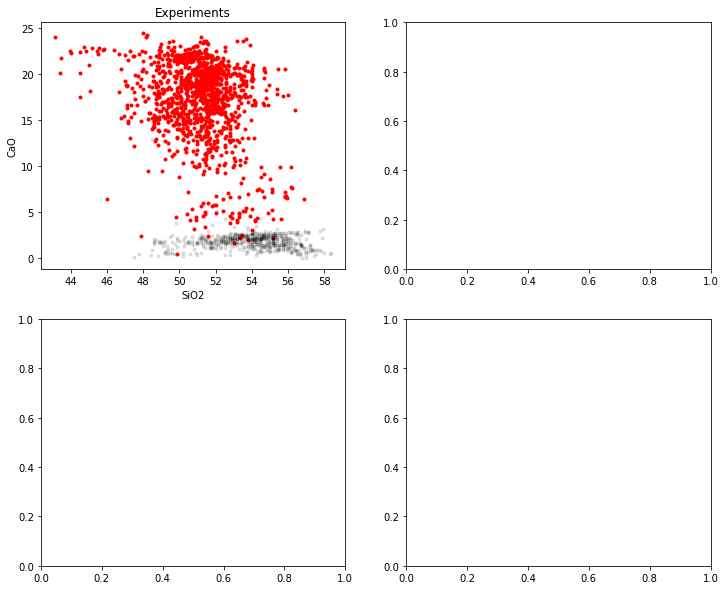

In [66]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 10))
ax0.plot(LEPR_Cpx['SiO2_Cpx'], LEPR_Cpx['CaO_Cpx'], '.r', label='Cpx (+pig)')
ax0.plot(LEPR_Opx['SiO2_Opx'], LEPR_Opx['CaO_Opx'], '.k', alpha=0.1, label='opx')
ax0.set_xlabel('SiO2')
ax0.set_ylabel('CaO')
ax0.set_title('Experiments')

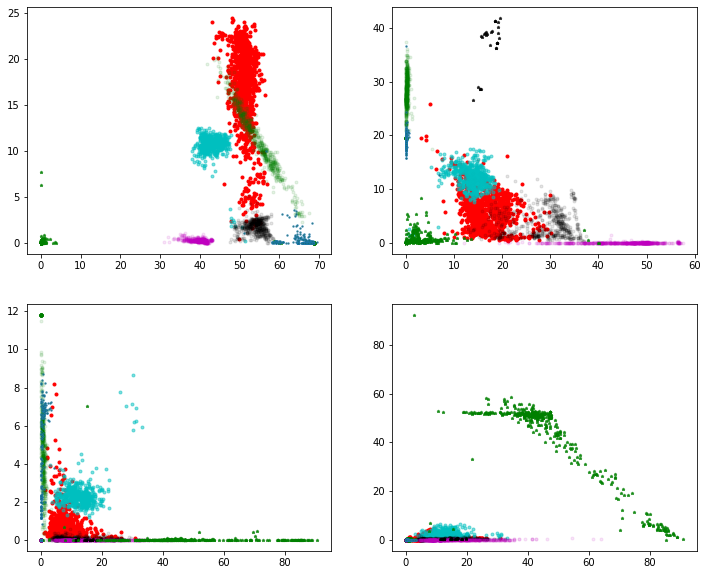

In [67]:
## Viualizing differences
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 10))
ax0.plot(LEPR_Cpx['SiO2_Cpx'], LEPR_Cpx['CaO_Cpx'], '.r')
ax0.plot(LEPR_Amp['SiO2_Amp'], LEPR_Amp['CaO_Amp'], '.c', alpha=0.5)
ax0.plot(LEPR_Opx['SiO2_Opx'], LEPR_Opx['CaO_Opx'], '.k', alpha=0.1)
ax0.plot(LEPR_Plag['SiO2_Plag'], LEPR_Plag['CaO_Plag'], '.g', alpha=0.1)
ax0.plot(LEPR_Ol['SiO2_Ol'], LEPR_Ol['CaO_Ol'], '.m', alpha=0.1)
ax0.plot(LEPR_Sp['SiO2_Sp'], LEPR_Sp['CaO_Sp'], '*k', alpha=0.7, ms=3)
ax0.plot(LEPR_Ox['SiO2_Sp'], LEPR_Ox['CaO_Sp'], '*g', alpha=0.7, ms=3)
ax0.plot(LEPR_Kspar['SiO2_Kspar'], LEPR_Kspar['CaO_Kspar'], '.', mfc='darkgreen', alpha=0.7, ms=3)

ax1.plot(LEPR_Cpx['MgO_Cpx'], LEPR_Cpx['Al2O3_Cpx'], '.r')
ax1.plot(LEPR_Amp['MgO_Amp'], LEPR_Amp['Al2O3_Amp'], '.c', alpha=0.5)
ax1.plot(LEPR_Opx['MgO_Opx'], LEPR_Opx['Al2O3_Opx'], '.k', alpha=0.1)
ax1.plot(LEPR_Plag['MgO_Plag'], LEPR_Plag['Al2O3_Plag'], '.g', alpha=0.1)
ax1.plot(LEPR_Ol['MgO_Ol'], LEPR_Ol['Al2O3_Ol'], '.m', alpha=0.1)
ax1.plot(LEPR_Sp['MgO_Sp'], LEPR_Sp['Al2O3_Sp'], '*k', alpha=0.7, ms=3)
ax1.plot(LEPR_Ox['MgO_Sp'], LEPR_Ox['Al2O3_Sp'], '*g', alpha=0.7, ms=3)
ax1.plot(LEPR_Kspar['MgO_Kspar'], LEPR_Kspar['Al2O3_Kspar'], '.', mfc='darkgreen', alpha=0.7, ms=3)


ax2.plot(LEPR_Cpx['FeOt_Cpx'], LEPR_Cpx['Na2O_Cpx'], '.r')
ax2.plot(LEPR_Amp['FeOt_Amp'], LEPR_Amp['Na2O_Amp'], '.c', alpha=0.5)
ax2.plot(LEPR_Opx['FeOt_Opx'], LEPR_Opx['Na2O_Opx'], '.k', alpha=0.1)
ax2.plot(LEPR_Plag['FeOt_Plag'], LEPR_Plag['Na2O_Plag'], '.g', alpha=0.1)
ax2.plot(LEPR_Ol['FeOt_Ol'], LEPR_Ol['Na2O_Ol'], '.m', alpha=0.1)
ax2.plot(LEPR_Sp['FeOt_Sp'], LEPR_Sp['Na2O_Sp'], '*k', alpha=0.7, ms=3)
ax2.plot(LEPR_Ox['FeOt_Sp'], LEPR_Ox['Na2O_Sp'], '*g', alpha=0.7, ms=3)
ax2.plot(LEPR_Kspar['FeOt_Kspar'], LEPR_Kspar['Na2O_Kspar'], '.', mfc='darkgreen', alpha=0.7, ms=3)

ax3.plot(LEPR_Cpx['FeOt_Cpx'], LEPR_Cpx['TiO2_Cpx'], '.r')
ax3.plot(LEPR_Amp['FeOt_Amp'], LEPR_Amp['TiO2_Amp'], '.c', alpha=0.5)
ax3.plot(LEPR_Opx['FeOt_Opx'], LEPR_Opx['TiO2_Opx'], '.k', alpha=0.1)
ax3.plot(LEPR_Plag['FeOt_Plag'], LEPR_Plag['TiO2_Plag'], '.g', alpha=0.1)
ax3.plot(LEPR_Ol['FeOt_Ol'], LEPR_Ol['TiO2_Ol'], '.m', alpha=0.1)
ax3.plot(LEPR_Sp['FeOt_Sp'], LEPR_Sp['TiO2_Sp'], '*k', alpha=0.7, ms=3)
ax3.plot(LEPR_Ox['FeOt_Sp'], LEPR_Ox['TiO2_Sp'], '*g', alpha=0.7, ms=3)
ax3.plot(LEPR_Kspar['FeOt_Kspar'], LEPR_Kspar['TiO2_Kspar'], '.', mfc='darkgreen', alpha=0.7, ms=3)




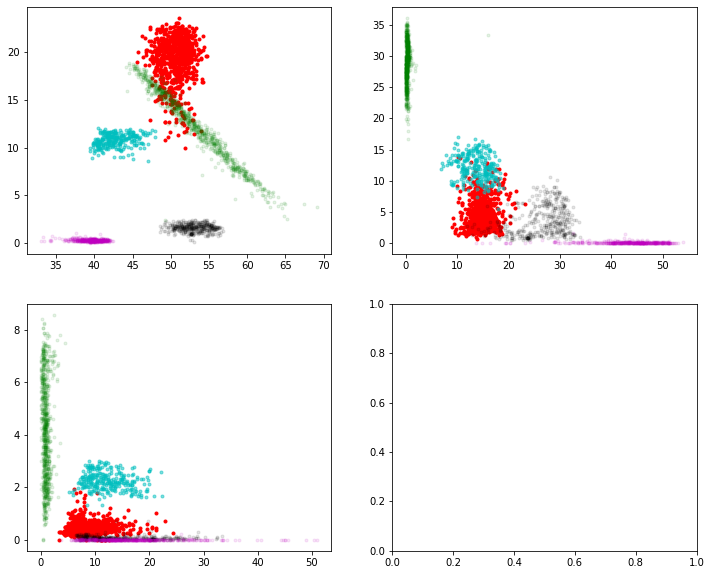

In [68]:
## Viualizing differences
fig, ((ax0, ax1), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
ax0.plot(PW_Cpx['SiO2_Cpx'], PW_Cpx['CaO_Cpx'], '.r')
ax0.plot(PW_Amp['SiO2_Amp'], PW_Amp['CaO_Amp'], '.c', alpha=0.5)
ax0.plot(PW_Opx['SiO2_Opx'], PW_Opx['CaO_Opx'], '.k', alpha=0.1)
ax0.plot(PW_Plag['SiO2_Plag'], PW_Plag['CaO_Plag'], '.g', alpha=0.1)
ax0.plot(PW_Ol['SiO2_Ol'], PW_Ol['CaO_Ol'], '.m', alpha=0.1)

ax1.plot(PW_Cpx['MgO_Cpx'], PW_Cpx['Al2O3_Cpx'], '.r')
ax1.plot(PW_Amp['MgO_Amp'], PW_Amp['Al2O3_Amp'], '.c', alpha=0.5)
ax1.plot(PW_Opx['MgO_Opx'], PW_Opx['Al2O3_Opx'], '.k', alpha=0.1)
ax1.plot(PW_Plag['MgO_Plag'], PW_Plag['Al2O3_Plag'], '.g', alpha=0.1)
ax1.plot(PW_Ol['MgO_Ol'], PW_Ol['Al2O3_Ol'], '.m', alpha=0.1)

ax2.plot(PW_Cpx['FeOt_Cpx'], PW_Cpx['Na2O_Cpx'], '.r')
ax2.plot(PW_Amp['FeOt_Amp'], PW_Amp['Na2O_Amp'], '.c', alpha=0.5)
ax2.plot(PW_Opx['FeOt_Opx'], PW_Opx['Na2O_Opx'], '.k', alpha=0.1)
ax2.plot(PW_Plag['FeOt_Plag'], PW_Plag['Na2O_Plag'], '.g', alpha=0.1)
ax2.plot(PW_Ol['FeOt_Ol'], PW_Ol['Na2O_Ol'], '.m', alpha=0.1)

## Tutorial from https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/

In [69]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [70]:
# In my example, 0 is amphibole, 1 is cpx, 2 is Opx, 3 is Plag, 4 is Ol

In [71]:
from sklearn.preprocessing import StandardScaler
X_test_noscaled=PW_X
y_test=PW_Y

X_train_noscaled=LEPR_X
y_train=LEPR_Y

scaler = StandardScaler().fit(X_train_noscaled)
X_train_scaled = scaler.transform(X_train_noscaled)
X_test_scaled=scaler.transform(X_test_noscaled)
# from sklearn.tree import DecisionTreeClassifier
# dtree_model = DecisionTreeClassifier(random_state=3).fit(X_train, y_train)
# svc_predictions = dtree_model.predict(X_test)

# cm = confusion_matrix(y_test, svc_predictions)

from sklearn.svm import SVC
svc_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_scaled, y_train)
svc_predictions = svc_model_linear.predict(X_test_scaled)
  
# model accuracy for X_test  
accuracy = svc_model_linear.score(X_test_scaled, y_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, svc_predictions)

In [72]:
accuracy

0.9996371552975326

In [73]:
len(PW_Cpx)

815

In [74]:
# 'amp', cpx+opx+pig, plag+alk, ol, sp, ox, alk
cm

array([[ 276,    1,    0,    0],
       [   0, 1220,    0,    0],
       [   0,    0,  819,    0],
       [   0,    0,    0,  440]], dtype=int64)

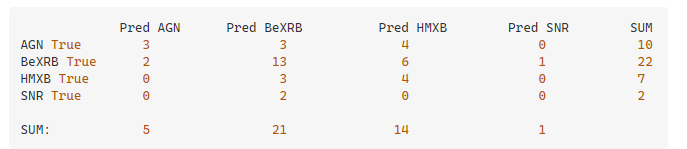

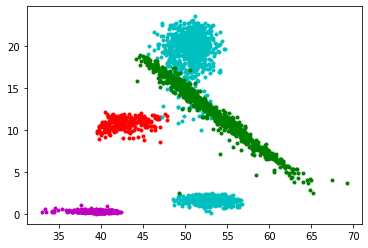

In [75]:
pred_amp_svc=svc_predictions==0
pred_px_svc=svc_predictions==1
pred_fspar_svc=svc_predictions==2
pred_ol_svc=svc_predictions==3
pred_sp_svc=svc_predictions==4
pred_ox_svc=svc_predictions==5

plt.plot(PW_Combo['SiO2'].loc[pred_amp_svc], PW_Combo['CaO'].loc[pred_amp_svc], '.r')
plt.plot(PW_Combo['SiO2'].loc[pred_px_svc], PW_Combo['CaO'].loc[pred_px_svc], '.c')
plt.plot(PW_Combo['SiO2'].loc[pred_fspar_svc], PW_Combo['CaO'].loc[pred_fspar_svc], '.g')
plt.plot(PW_Combo['SiO2'].loc[pred_ol_svc], PW_Combo['CaO'].loc[pred_ol_svc], '.m')
plt.plot(PW_Combo['SiO2'].loc[pred_sp_svc], PW_Combo['CaO'].loc[pred_sp_svc], '*k', alpha=0.7, ms=3)
plt.plot(PW_Combo['SiO2'].loc[pred_ox_svc], PW_Combo['CaO'].loc[pred_ox_svc],  '*g', alpha=0.7, ms=3)



## True Cpxs -Perfect classification!?

In [76]:
## Currently none classified as Pigeonites
print('Number predicted Cpx')
sum(svc_predictions==1)

Number predicted Cpx


1221

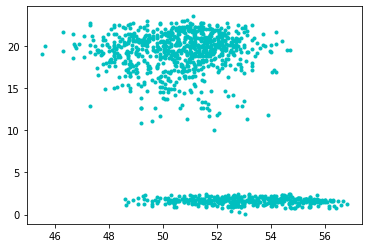

In [77]:

Actual_Cpx=PW_Combo['Phase']==1
plt.plot(PW_Combo['SiO2'].loc[pred_amp_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_amp_svc&Actual_Cpx], '.r')
plt.plot(PW_Combo['SiO2'].loc[pred_px_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_px_svc&Actual_Cpx], '.c')
plt.plot(PW_Combo['SiO2'].loc[pred_fspar_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_fspar_svc&Actual_Cpx], '.g')
plt.plot(PW_Combo['SiO2'].loc[pred_ol_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_ol_svc&Actual_Cpx], '.m')
plt.plot(PW_Combo['SiO2'].loc[pred_sp_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_sp_svc&Actual_Cpx], '*k', alpha=0.7, ms=3)
plt.plot(PW_Combo['SiO2'].loc[pred_ox_svc&Actual_Cpx], PW_Combo['CaO'].loc[pred_ox_svc&Actual_Cpx],  '*g', alpha=0.7, ms=3)


## True Plags
- Things one is cpx, and 2 are opx. This is very feasible. 

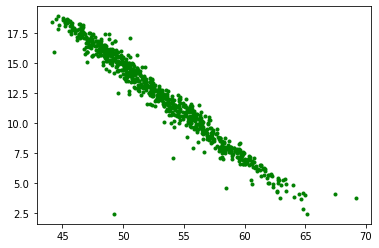

In [81]:
Actual_Plag=PW_Combo['Phase']==2
plt.plot(PW_Combo['SiO2'].loc[pred_amp_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_amp_svc&Actual_Plag], '.r')
plt.plot(PW_Combo['SiO2'].loc[pred_px_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_px_svc&Actual_Plag], '.c')
plt.plot(PW_Combo['SiO2'].loc[pred_fspar_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_fspar_svc&Actual_Plag], '.g')
plt.plot(PW_Combo['SiO2'].loc[pred_ol_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_ol_svc&Actual_Plag], '.m')
plt.plot(PW_Combo['SiO2'].loc[pred_sp_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_sp_svc&Actual_Plag], '*k', alpha=0.7, ms=3)
plt.plot(PW_Combo['SiO2'].loc[pred_ox_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_ox_svc&Actual_Plag],  '*g', alpha=0.7, ms=3)


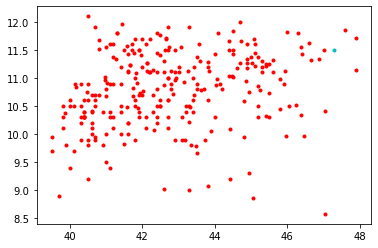

In [82]:
Actual_Amp=PW_Combo['Phase']==0
plt.plot(PW_Combo['SiO2'].loc[pred_amp_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_amp_svc&Actual_Amp], '.r')
plt.plot(PW_Combo['SiO2'].loc[pred_px_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_px_svc&Actual_Amp], '.c')
plt.plot(PW_Combo['SiO2'].loc[pred_fspar_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_fspar_svc&Actual_Amp], '.g')
plt.plot(PW_Combo['SiO2'].loc[pred_ol_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_ol_svc&Actual_Amp], '.m')
plt.plot(PW_Combo['SiO2'].loc[pred_sp_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_sp_svc&Actual_Amp], '*k', alpha=0.7, ms=3)
plt.plot(PW_Combo['SiO2'].loc[pred_ox_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_ox_svc&Actual_Amp],  '*g', alpha=0.7, ms=3)


In [62]:
## CHeck dataset is wrong - Shift it off. 
PW_Combo.loc[pred_pig_svc&Actual_Plag]

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,Sample_ID,Phase,NiO
1699,50.599998,29.400000,0.5,0.0,0.0,17.1,2.2,0.2,0.0,0.0,202.0,3,NaN
1700,53.200001,29.799999,0.5,0.0,0.0,12.8,3.5,0.2,0.0,0.0,203.0,3,NaN


##### These are from Peterman et al. And clearly not the phase they say they are...

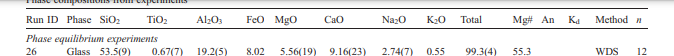

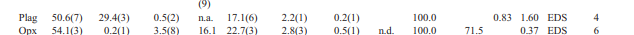

In [65]:
PW_Combo.loc[pred_kspar_svc&Actual_Plag]

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,Sample_ID,Phase,NiO
1940,49.250000,0.000000,33.3200,0.3900,0.0000,16.0500,2.450000,0.030000,0.0000,0.0,443.0,3,NaN
2085,65.147467,0.202333,19.9236,0.6894,0.0033,0.0459,2.484467,7.431167,1.8894,0.0,588.0,3,NaN
2282,67.410000,0.000000,17.9700,2.4400,0.0000,0.4400,4.090000,5.080000,1.1000,0.0,785.0,3,NaN
2286,69.190000,0.000000,16.6500,2.9000,0.0000,0.3800,3.740000,6.040000,0.7800,0.0,789.0,3,NaN


In [ ]:
## Why doesnt it classify as oxide

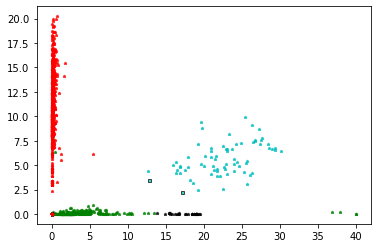

In [77]:
MisClass_Pig=PW_Combo.loc[pred_pig_svc&Actual_Plag]
plt.plot(LEPR_Sp['MgO_Sp'], LEPR_Sp['CaO_Sp'], '*k', alpha=0.7, ms=3)
plt.plot(LEPR_Ox['MgO_Sp'], LEPR_Ox['CaO_Sp'], '*g', alpha=0.7, ms=3)
plt.plot(LEPR_Pig['MgO_Cpx'], LEPR_Pig['CaO_Cpx'], '*c', alpha=0.7, ms=3)
plt.plot(LEPR_Plag['MgO_Plag'], LEPR_Plag['CaO_Plag'], '*r', alpha=0.7, ms=3)

plt.plot(MisClass_Pig['MgO'], MisClass_Pig['CaO'], 'sk', mfc='c', alpha=0.7, ms=3)


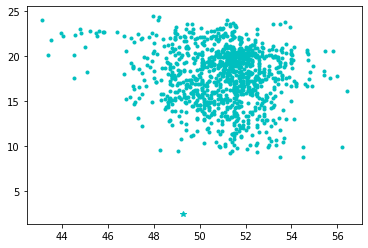

In [49]:
plt.plot(LEPR_Cpx['SiO2_Cpx'], LEPR_Cpx['CaO_Cpx'], '.c')

plt.plot(PW_Combo['SiO2'].loc[pred_cpx_svc&Actual_Plag], PW_Combo['CaO'].loc[pred_cpx_svc&Actual_Plag], '*c')


## True amphiboles

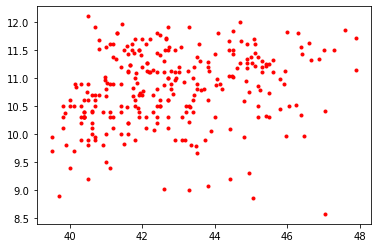

In [80]:
pred_amp_svc=svc_predictions==0
pred_cpx_svc=svc_predictions==1
pred_opx_svc=svc_predictions==2
pred_plag_svc=svc_predictions==3
pred_ol_svc=svc_predictions==4

Actual_Amp=PW_Combo['Phase']==0
plt.plot(PW_Combo['SiO2'].loc[pred_amp_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_amp_svc&Actual_Amp], '.r')
plt.plot(PW_Combo['SiO2'].loc[pred_cpx_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_cpx_svc&Actual_Amp], '.c')
plt.plot(PW_Combo['SiO2'].loc[pred_opx_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_opx_svc&Actual_Amp], '.k')
plt.plot(PW_Combo['SiO2'].loc[pred_plag_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_plag_svc&Actual_Amp], '.g')
plt.plot(PW_Combo['SiO2'].loc[pred_ol_svc&Actual_Amp], PW_Combo['CaO'].loc[pred_ol_svc&Actual_Amp], '.m')

In [ ]:
## Writing this all as a function. 

## Saving the variables

In [ ]:
from pickle import dump
import pickle
dump(scaler, open('scaler_MinClass.pkl', 'wb'))
dump(svc_model_linear, open('svc_model_linear_MinClass.pkl', 'wb'))
